In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- 1. Mount Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# --- 2. Define All Project Paths ---
BASE_DIR = "/content/drive/MyDrive/Pneumonia_Advanced_Project/"

# --- Source Paths (on Drive) ---
CSV_PATH = os.path.join(BASE_DIR, "2_processed_data", "master_labels_balanced.csv")
SOURCE_IMAGE_DIR = os.path.join(BASE_DIR, "2_processed_data", "images") # The 30,000 images

# --- Destination Folders ---
DRIVE_DEST_IMAGES = os.path.join(BASE_DIR, "2_processed_data", "images_balanced_4200")
LOCAL_IMAGE_DIR = "/content/local_images" # The super-fast local folder for training

# --- Model Save Path ---
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "4_models", "v1_image_model.h5")

print("All paths defined.")

Mounting Google Drive...
Mounted at /content/drive
All paths defined.


In [ ]:
import os
import shutil
import time

# --- 1. Define Paths (from Cell 1) ---
BASE_DIR = "/content/drive/MyDrive/Pneumonia_Advanced_Project/"
# This is your NEW, CLEAN folder on Drive
DRIVE_IMAGE_DIR = os.path.join(BASE_DIR, "2_processed_data", "images_balanced_4200")
# This is the super-fast local folder for training
LOCAL_IMAGE_DIR = "/content/local_images"

# --- 2. [Local Copy] Copy Clean Folder to Colab Disk ---
print(f"\n--- Copying '{os.path.basename(DRIVE_IMAGE_DIR)}' to local Colab disk ---")
if os.path.exists(LOCAL_IMAGE_DIR):
    print(f"'{LOCAL_IMAGE_DIR}' already exists. Deleting it for a fresh copy.")
    shutil.rmtree(LOCAL_IMAGE_DIR)

os.makedirs(LOCAL_IMAGE_DIR)
print(f"Created new local folder: {LOCAL_IMAGE_DIR}")

start_time = time.time()

# Get the list of all 4200 filenames to copy
try:
    image_filenames = os.listdir(DRIVE_IMAGE_DIR)
    total_images = len(image_filenames)
    print(f"Found {total_images} images to copy...")
except Exception as e:
    print(f"ERROR: Could not read folder '{DRIVE_IMAGE_DIR}'. {e}")
    # Stop the script if the folder can't be read
    raise

copy_count = 0
errors = 0

# --- 3. Start the Copy Loop ---
for filename in image_filenames:
    source_path = os.path.join(DRIVE_IMAGE_DIR, filename)
    destination_path = os.path.join(LOCAL_IMAGE_DIR, filename)

    try:
        shutil.copy(source_path, destination_path)
        copy_count += 1

        # --- This is the new, clearer counter ---
        # It prints a NEW line every 250 images
        if copy_count % 250 == 0:
            print(f"  ...Copied {copy_count} / {total_images} images")

    except Exception as e:
        print(f"\nError copying {filename}: {e}")
        errors += 1

end_time = time.time()

# Print a final "Done" message
print(f"\n--- Local copy complete in {end_time - start_time:.2f} seconds ---")
print(f"Successfully copied: {copy_count} images")
print(f"Failed or skipped:   {errors} images")

if copy_count != total_images:
    print(f"WARNING: Expected {total_images} images, but only copied {copy_count}.")
else:
    print("File count is correct. Ready for the next step.")


--- Copying 'images_balanced_4200' to local Colab disk ---
Created new local folder: /content/local_images
Found 4200 images to copy...
  ...Copied 250 / 4200 images
  ...Copied 500 / 4200 images
  ...Copied 750 / 4200 images
  ...Copied 1000 / 4200 images
  ...Copied 1250 / 4200 images
  ...Copied 1500 / 4200 images
  ...Copied 1750 / 4200 images
  ...Copied 2000 / 4200 images
  ...Copied 2250 / 4200 images
  ...Copied 2500 / 4200 images
  ...Copied 2750 / 4200 images
  ...Copied 3000 / 4200 images
  ...Copied 3250 / 4200 images
  ...Copied 3500 / 4200 images
  ...Copied 3750 / 4200 images
  ...Copied 4000 / 4200 images

--- Local copy complete in 267.83 seconds ---
Successfully copied: 4200 images
Failed or skipped:   0 images
File count is correct. Ready for the next step.


In [ ]:
# --- 7. Load CSV and Prepare Data ---
CSV_PATH = os.path.join(BASE_DIR, "2_processed_data", "master_labels_balanced.csv")
print(f"\nLoading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Preparing data for training...")

# Convert text labels ("COVID-19", "Normal") to numbers (0, 1, 2...)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(f"Labels found ({len(label_encoder.classes_)}): {label_encoder.classes_}")

# CRITICAL: Update the filepath to point to the *NEW LOCAL* directory
df['filepath'] = df['filename'].apply(lambda x: os.path.join(LOCAL_IMAGE_DIR, x))

# --- 8. Split the Data ---
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label_encoded']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label_encoded']
)
print(f"Data split: {len(train_df)} train, {len(val_df)} validation, {len(test_df)} test")


Loading CSV from: /content/drive/MyDrive/Pneumonia_Advanced_Project/2_processed_data/master_labels_balanced.csv
Preparing data for training...
Labels found (6): ['COVID-19' 'Lung Opacity' 'Normal' 'Pneumonia (Bacterial)'
 'Pneumonia (Viral)' 'Tuberculosis']
Data split: 2940 train, 630 validation, 630 test


In [ ]:
# --- 9. Define High-Performance tf.data Pipeline Functions ---
print("Defining tf.data helper functions...")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # Your 15GB GPU can handle this
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE # For pipeline optimization

def load_and_preprocess(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

def create_dataset(dataframe, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (dataframe['filepath'].values, dataframe['label_encoded'].values)
    )
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.cache() # Cache from the fast local disk
    if is_training:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

print("Functions defined.")

Defining tf.data helper functions...
Functions defined.


In [ ]:
# --- 10. Create the Datasets ---
print("Creating high-performance tf.data pipelines...")
train_ds = create_dataset(train_df, is_training=True)
val_ds = create_dataset(val_df, is_training=False)
test_ds = create_dataset(test_df, is_training=False)
print("Data pipelines built and ready.")

Creating high-performance tf.data pipelines...
Data pipelines built and ready.


In [ ]:
# --- 11. Build the Model (with GPU Augmentation) ---
print("\nBuilding model...")
# GPU-powered augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
], name="data_augmentation")

# Input Layer
inputs = Input(shape=IMG_SIZE + (3,), name="input_layer")
x = data_augmentation(inputs)

# Base Model (DenseNet121)
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    name="densenet121"
)
base_model.trainable = False # Freeze the base

# Custom Head
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create and Compile for Stage 1
model = Model(inputs=inputs, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Building model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,446 (27.85 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# --- 12. [STAGE 1] Train the Head ---
print("\n--- STAGE 1: Training the Head ---")
EPOCHS_STAGE_1 = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE_1,
    validation_data=val_ds
)
print("Stage 1 training complete.")


--- STAGE 1: Training the Head ---
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.3994 - loss: 1.5067 - val_accuracy: 0.6333 - val_loss: 0.9398
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.6120 - loss: 0.9682 - val_accuracy: 0.6714 - val_loss: 0.8050
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.6486 - loss: 0.8679 - val_accuracy: 0.6968 - val_loss: 0.7419
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.6511 - loss: 0.8335 - val_accuracy: 0.7000 - val_loss: 0.7190
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.6686 - loss: 0.7768 - val_accuracy: 0.6810 - val_loss: 0.7160
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.7061 - loss: 0.7315 - val_accuracy: 0.7079 - val_loss: 0.7025
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.6891 - loss: 0.7160 - val_accuracy: 0.6889 - val_loss: 0.7223
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accura

In [ ]:
# --- 13. [STAGE 2] Fine-Tune the Full Model ---
print("\n--- STAGE 2: Fine-Tuning the Full Model ---")
base_model.trainable = True # Unfreeze the base

# Re-compile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define Callbacks for fine-tuning
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1
)

EPOCHS_STAGE_2 = 20 # Give it more time to fine-tune
total_epochs = EPOCHS_STAGE_1 + EPOCHS_STAGE_2

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where we left off
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)
print("Stage 2 (fine-tuning) complete.")


--- STAGE 2: Fine-Tuning the Full Model ---
Epoch 10/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4815 - loss: 1.5659
Epoch 10: val_accuracy improved from -inf to 0.68413, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 150s 790ms/step - accuracy: 0.4820 - loss: 1.5636 - val_accuracy: 0.6841 - val_loss: 0.8132 - learning_rate: 1.0000e-05
Epoch 11/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6313 - loss: 0.9122
Epoch 11: val_accuracy improved from 0.68413 to 0.68571, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 727ms/step - accuracy: 0.6314 - loss: 0.9119 - val_accuracy: 0.6857 - val_loss: 0.8518 - learning_rate: 1.0000e-05
Epoch 12/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.6788 - loss: 0.7783
Epoch 12: val_accuracy did not improve from 0.68571
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 684ms/step - accuracy: 0.6790 - loss: 0.7781 - val_accuracy: 0.6810 - val_loss: 0.8087 - learning_rate: 1.0000e-05
Epoch 13/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7074 - loss: 0.7118
Epoch 13: val_accuracy improved from 0.68571 to 0.69683, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 721ms/step - accuracy: 0.7076 - loss: 0.7113 - val_accuracy: 0.6968 - val_loss: 0.7549 - learning_rate: 1.0000e-05
Epoch 14/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7338 - loss: 0.6270
Epoch 14: val_accuracy improved from 0.69683 to 0.71587, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 721ms/step - accuracy: 0.7338 - loss: 0.6270 - val_accuracy: 0.7159 - val_loss: 0.7362 - learning_rate: 1.0000e-05
Epoch 15/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7505 - loss: 0.5818
Epoch 15: val_accuracy improved from 0.71587 to 0.73175, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 725ms/step - accuracy: 0.7506 - loss: 0.5818 - val_accuracy: 0.7317 - val_loss: 0.6728 - learning_rate: 1.0000e-05
Epoch 16/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7768 - loss: 0.5806
Epoch 16: val_accuracy did not improve from 0.73175
92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 709ms/step - accuracy: 0.7767 - loss: 0.5806 - val_accuracy: 0.7238 - val_loss: 0.6830 - learning_rate: 1.0000e-05
Epoch 17/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7897 - loss: 0.5401
Epoch 17: val_accuracy improved from 0.73175 to 0.75556, saving model to /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 724ms/step - accuracy: 0.7897 - loss: 0.5400 - val_accuracy: 0.7556 - val_loss: 0.6408 - learning_rate: 1.0000e-05
Epoch 18/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7870 - loss: 0.5183
Epoch 18: val_accuracy did not improve from 0.75556
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 699ms/step - accuracy: 0.7870 - loss: 0.5182 - val_accuracy: 0.7349 - val_loss: 0.7045 - learning_rate: 1.0000e-05
Epoch 19/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7902 - loss: 0.5249
Epoch 19: val_accuracy did not improve from 0.75556

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 684ms/step - accuracy: 0.7903 - loss: 0.5247 - val_accuracy: 0.7206 - val_loss: 0.8740 - learning_rate: 1.0000e-05
Epoch 20/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8085 - loss: 0.4766
Epoch 20: val_accuracy did not improve from 0.75556
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 685ms/step - accuracy: 0.8085 - los


--- SAVING AND EVALUATING ---
Loading best saved model from: /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


Training history plot saved to: /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_training_history.png


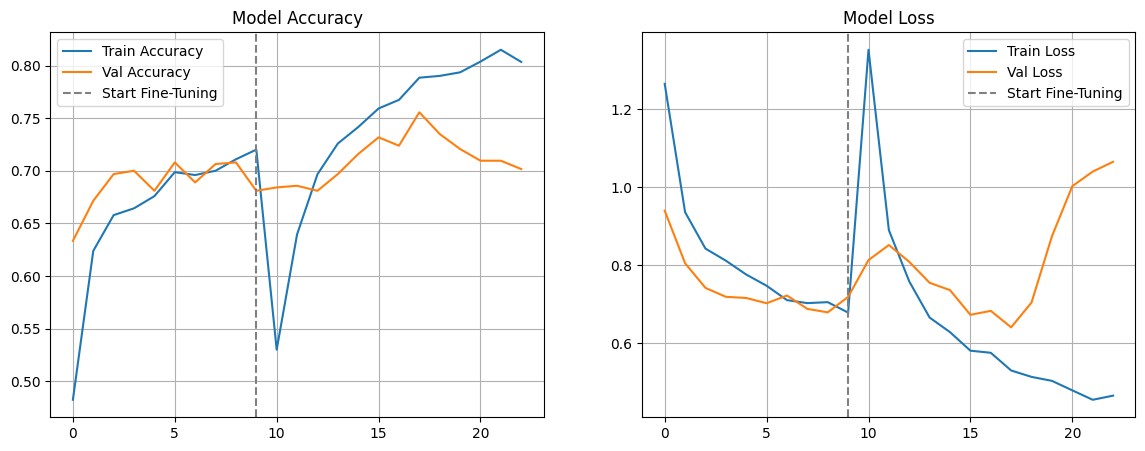


--- Evaluating on Test Set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.7420 - loss: 0.6755
Test Loss: 0.6591
Test Accuracy: 73.65%

--- PHASE 2 COMPLETE ---
Your best model is saved at: /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


In [ ]:
# --- 14. Save and Evaluate Your Model ---
print("\n--- SAVING AND EVALUATING ---")

# Load the best model saved by ModelCheckpoint
print(f"Loading best saved model from: {MODEL_SAVE_PATH}")
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Plot the training history
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.axvline(x=EPOCHS_STAGE_1-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=EPOCHS_STAGE_1-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plot_path = os.path.join(BASE_DIR, "4_models", "v1_training_history.png")
plt.savefig(plot_path)
print(f"Training history plot saved to: {plot_path}")
plt.show()

# Evaluate on the UNSEEN test set
print("\n--- Evaluating on Test Set ---")
results = best_model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

print(f"\n--- PHASE 2 COMPLETE ---")
print(f"Your best model is saved at: {MODEL_SAVE_PATH}")